In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.linear_model import OrthogonalMatchingPursuit, OrthogonalMatchingPursuitCV
from sklearn.ensemble import VotingRegressor, BaggingRegressor
from sklearn.svm import SVR
import warnings
warnings.filterwarnings('ignore')

In [5]:
path = 'Phase/'

x1_train = pd.read_csv(path+'x1_phase_train.csv')
x2_train = pd.read_csv(path+'x2_phase_train.csv')
f1_train = pd.read_csv(path+'f_phase_train.csv')
f1_test = pd.read_csv(path+'f_phase_test.csv')
x1_test = pd.read_csv(path+'x1_phase_test.csv')
x2_test = pd.read_csv(path+'x2_phase_test.csv')
print(len(x1_train),len(x1_test),len(f1_train),len(f1_test))
X_train = pd.DataFrame(data = np.concatenate((x1_train,x2_train),axis=1),columns = ['p1','p2'])
X_test = pd.DataFrame(data = np.concatenate((x1_test,x2_test),axis=1),columns = ['p1','p2'])
X_train.head()

94064 80606 94064 80606


,p1,p2
0,-0.0000,-0.0000
1,-0.0159,-0.0000
2,-0.0159,0.0171
3,-0.0159,0.0171
4,-0.0000,0.0329


In [6]:
from scipy import *
from scipy.linalg import norm, pinv
import math
 
from matplotlib import pyplot as plt
 
class RBF:
     
    def __init__(self, indim, numCenters, outdim):
        self.indim = indim
        self.outdim = outdim
        self.numCenters = numCenters
        self.centers = [np.random.uniform(-1, 1, indim) for i in range(numCenters)]
        self.beta = 8
        self.W = np.random.random((self.numCenters, self.outdim))
         
    def _basisfunc(self, c, d):
        assert len(d) == self.indim
        return norm(c-d)**3
     
    def _calcAct(self, X):
        # calculate activations of RBFs
        G = np.zeros((X.shape[0], self.numCenters), float)
        for ci, c in enumerate(self.centers):
            for xi, x in enumerate(X):
                G[xi,ci] = self._basisfunc(c, x)
        return G
     
    def train(self, X, Y):
        """ X: matrix of dimensions n x indim 
            y: column vector of dimension n x 1 """
         
        # choose random center vectors from training set
        rnd_idx = np.random.permutation(X.shape[0])[:self.numCenters]
        self.centers = [X[i,:] for i in rnd_idx]
         
        #print("center", self.centers)
        # calculate activations of RBFs
        G = self._calcAct(X)
        #print(G)
         
        # calculate output weights (pseudoinverse)
        self.W = np.dot(pinv(G), Y)
         
    def test(self, X):
        """ X: matrix of dimensions n x indim """
         
        G = self._calcAct(X)
        Y = np.dot(G, self.W)
        return Y

In [23]:
def get_results(t,m):
    l1 = len(X_train)
    l2 = len(X_test)
    x_train = [[0 for _ in range(m*2)] for _ in range(l1-t*(m-1))]
    x_test = [[0 for _ in range(m*2)] for _ in range(l2-t*(m-1))]

    for i in range(l1-t*(m-1)):
        for j in range(m):
            x_train[i][j]=X_train.iloc[t*(m-1)+i-2*j,0]
            x_train[i][j+m]=X_train.iloc[t*(m-1)+i-2*j,1]

    y_train = f1_train.iloc[t*(m-1):]

    for i in range(l2-t*(m-1)):
        for j in range(m):
            x_test[i][j]=X_test.iloc[t*(m-1)+i-2*j,0]
            x_test[i][j+m]=X_test.iloc[t*(m-1)+i-2*j,1]
    y_test = f1_test.iloc[t*(m-1):]
    x_train,x_test = np.array(x_train),np.array(x_test)
    t1 = datetime.now()
    rf = RandomForestRegressor()
    rf.fit(x_train,y_train)
    t2 = datetime.now()
    print('Time taken by Random Forest',t2-t1)
    
    y1_pred = rf.predict(x_test)
    y1 = y1_pred
    print('Root Mean Squared error of Random Forest',sqrt(mean_squared_error(y_test,y1_pred)))
    
    error = []
    for i in range(len(y_test)):
        error.append(abs(y1_pred[i]-y_test.iloc[i,0]))
    print('Minimum Error =',min(error))
    print('Maximum Error =',max(error))
    error1 = sorted(error)
    print('Median Value of Error =',error1[len(error)//2])
    '''
    importances = rf.feature_importances_
    plt.figure(figsize=(20,5))
    x_plot = ['x1(n{})'.format(-i) for i in range(0,m*t,t)] + ['x2(n{})'.format(-i) for i in range(0,m*t,t)]
    plt.plot(x_plot,importances, label = 'Importance Plot')
    plt.legend()
    plt.xlabel('Feature')
    plt.ylabel('Feature importance')
    plt.title('Importance plot for random forest')
    plt.show()'''
    
    # RBF MODEL
    rbf = RBF(2*m, 100, 1)
    t1 = datetime.now()
    rbf.train(x_train, y_train)
    t2 = datetime.now()
    
    print('\n\nTime taken by RBF Model: ',t2-t1)
    y1_pred = rbf.test(x_test)
    y2 = y1_pred
    print('Root mean square error of RBF Model: ',sqrt(mean_squared_error(y_test,y1_pred)))
    
    error5 = []
    for i in range(len(y_test)):
        error5.append(abs(y1_pred[i]-y_test.iloc[i,0]))
    print('Minimum Error =',min(error5))
    print('Maximum Error =',max(error5))
    error6 = sorted(error5)
    print('Median Value of Error =',error6[len(error5)//2])
    
    
    # SVR MODEL
    t1 = datetime.now()
    clf = SVR()
    clf.fit(x_train,y_train)
    t2 = datetime.now()

    print('\n\nTime taken by SVR Model: ',t2-t1)
    y1_pred = clf.predict(x_test)
    y4 = y1_pred
    print('Root mean square error of SVR Model: ',sqrt(mean_squared_error(y_test,y1_pred)))
    
    error7 = []
    for i in range(len(y_test)):
        error7.append(abs(y1_pred[i]-y_test.iloc[i,0]))
    print('Minimum Error =',min(error7))
    print('Maximum Error =',max(error7))
    error8 = sorted(error7)
    print('Median Value of Error =',error8[len(error8)//2])
    
    # COMPARISON
    plt.figure(figsize=(20,5))
    plt.plot(list(range(6000)),y1[:6000], label = 'Random Forest')
    plt.plot(list(range(6000)),y2[:6000], label = 'RBF')
    plt.plot(list(range(6000)),y4[:6000], label = 'SVR')
    plt.plot(list(range(6000)),y_test[:6000], label = 'Actual')
    plt.legend()
    plt.xlabel('Time (in ms)')
    plt.ylabel('Force')
    plt.title('Models prediction comparison')
    plt.show()
    
    plt.plot(list(range(len(y1_pred))),error5, label = 'Error of RBF Model')
    plt.plot(list(range(len(y1_pred))),error, label = 'Error of Random Forest')
    plt.plot(list(range(len(y1_pred))),error7, label = 'Error of SVR Model')
    plt.legend()
    plt.title('Error as a function of time')
    plt.show()
    
    # closer view at initial points
    plt.figure(figsize=(20,5))
    plt.plot(list(range(6000)),error5[:6000], label = 'RBF Model')
    plt.plot(list(range(6000)),error[:6000], label = 'Random Forest')
    plt.plot(list(range(6000)),error7[:6000], label = 'SVR Model')
    plt.legend()
    plt.title('Error as a function of time')
    plt.show()
    
    return x_train,x_test,y_train,y_test

Time taken by Random Forest 0:01:04.835085
Root Mean Squared error of Random Forest 0.11965409188305569
Minimum Error = 4.999999999866223e-07
Maximum Error = 1.6698620000000006
Median Value of Error = 0.01823100000000004


Time taken by RBF Model:  0:02:33.584338
Root mean square error of RBF Model:  0.044646087024622166
Minimum Error = [1.12574178e-06]
Maximum Error = [0.64590092]
Median Value of Error = [0.01704755]


Time taken by SVR Model:  0:00:46.088671
Root mean square error of SVR Model:  0.05432438525375195
Minimum Error = 8.628318616255015e-07
Maximum Error = 0.7211378682591549
Median Value of Error = 0.03395877979553008


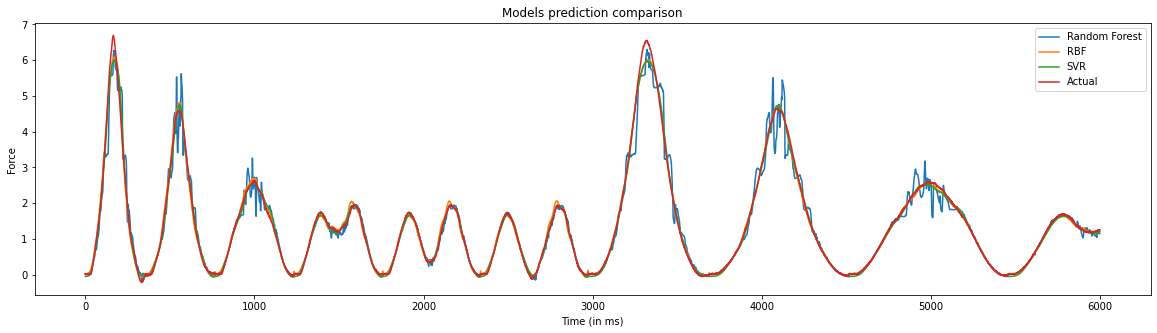

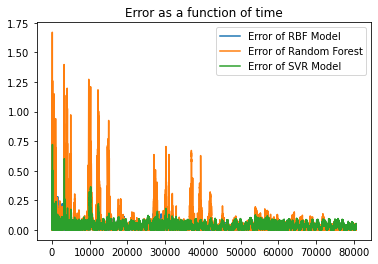

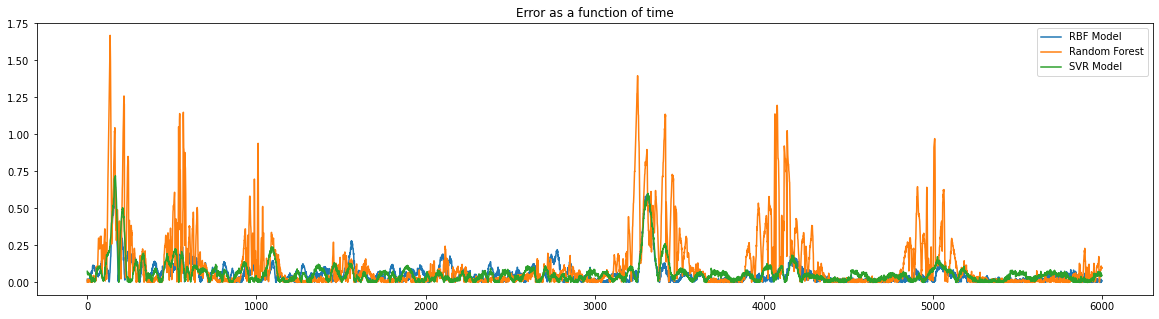

In [24]:
x_train,x_test,y_train,y_test = get_results(t=3, m=2)

In [25]:
from catboost import CatBoostRegressor
cat = CatBoostRegressor()
t1 = datetime.now()
cat.fit(x_train,y_train)
t2 = datetime.now()

Learning rate set to 0.083942
0:	learn: 0.8445478	total: 16ms	remaining: 16s
1:	learn: 0.7782230	total: 22.2ms	remaining: 11.1s
2:	learn: 0.7172755	total: 28ms	remaining: 9.31s
3:	learn: 0.6610228	total: 34.5ms	remaining: 8.59s
4:	learn: 0.6095857	total: 39.8ms	remaining: 7.93s
5:	learn: 0.5623634	total: 45.3ms	remaining: 7.51s
6:	learn: 0.5189148	total: 50.3ms	remaining: 7.13s
7:	learn: 0.4791793	total: 54.9ms	remaining: 6.81s
8:	learn: 0.4431808	total: 86.9ms	remaining: 9.57s
9:	learn: 0.4099463	total: 112ms	remaining: 11.1s
10:	learn: 0.3792885	total: 133ms	remaining: 12s
11:	learn: 0.3515986	total: 139ms	remaining: 11.4s
12:	learn: 0.3255897	total: 145ms	remaining: 11s
13:	learn: 0.3020374	total: 152ms	remaining: 10.7s
14:	learn: 0.2801384	total: 179ms	remaining: 11.8s
15:	learn: 0.2604828	total: 201ms	remaining: 12.4s
16:	learn: 0.2423000	total: 210ms	remaining: 12.2s
17:	learn: 0.2258627	total: 216ms	remaining: 11.8s
18:	learn: 0.2107924	total: 221ms	remaining: 11.4s
19:	learn: 0

In [26]:
print(y_train.shape,y_test.shape)

(94061, 1) (80603, 1)


In [27]:
print('Time taken by CATBOOST Model: ',t2-t1)
y1_pred = cat.predict(x_test)
y4 = y1_pred
print('Root mean square error of CATBOOST Model: ',sqrt(mean_squared_error(y_test,y1_pred)))
    
error7 = []
for i in range(len(y_test)):
    error7.append(abs(y1_pred[i]-y_test.iloc[i,0]))
print('Minimum Error =',min(error7))
print('Maximum Error =',max(error7))
error8 = sorted(error7)
print('Median Value of Error =',error8[len(error8)//2])

Time taken by CATBOOST Model:  0:00:22.651425
Root mean square error of CATBOOST Model:  0.06426148511249649
Minimum Error = 5.218854904898151e-07
Maximum Error = 0.8036144899985427
Median Value of Error = 0.02012745570543517


# Using present informantion

Time taken by Random Forest 0:00:35.822037
Root Mean Squared error of Random Forest 0.12307383932930611
Minimum Error = 5.64285714287939e-07
Maximum Error = 1.5723630000000002
Median Value of Error = 0.028038000000000285


Time taken by RBF Model:  0:02:34.560885
Root mean square error of RBF Model:  0.06177214640943034
Minimum Error = [3.24084051e-07]
Maximum Error = [0.91557611]
Median Value of Error = [0.02244363]


Time taken by SVR Model:  0:01:19.198828
Root mean square error of SVR Model:  0.061943869390992
Minimum Error = 1.1168435908315288e-06
Maximum Error = 0.7746989586733894
Median Value of Error = 0.03870335059313343


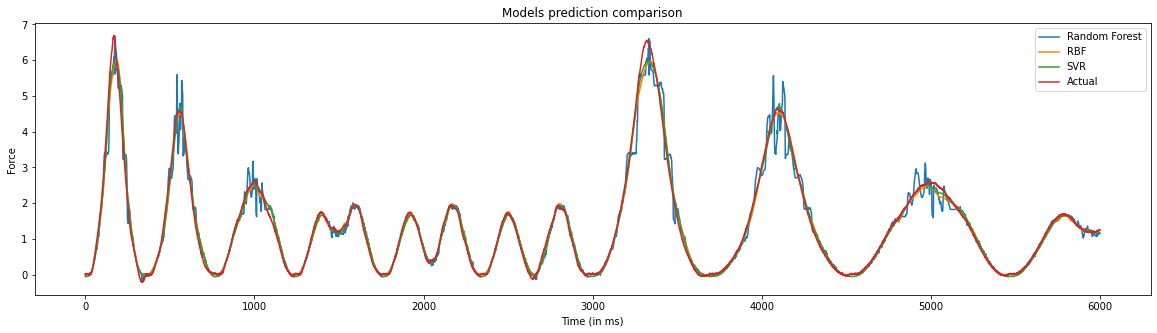

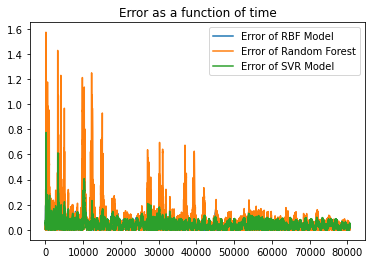

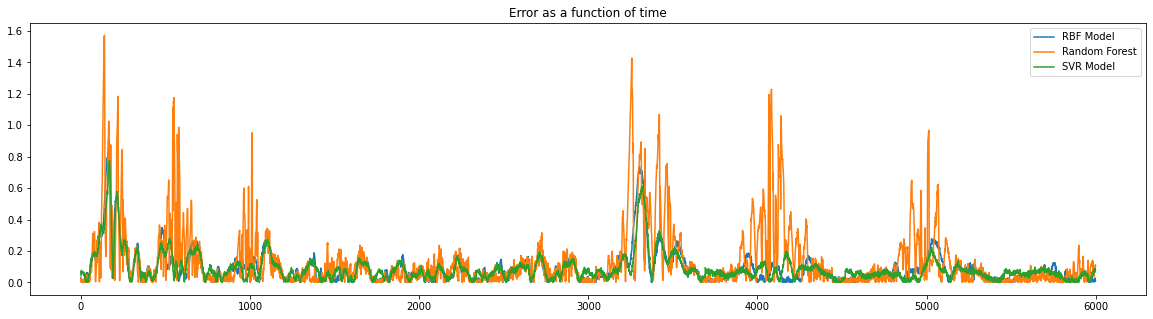

In [19]:
x_train,x_test,y_train,y_test = get_results(t=1, m=1)

In [20]:
print(x_train.shape,x_test.shape)

(94064, 2) (80606, 2)


In [21]:
cat = CatBoostRegressor()
t1 = datetime.now()
cat.fit(x_train,y_train)
t2 = datetime.now()

Learning rate set to 0.083942
0:	learn: 0.8445447	total: 9.24ms	remaining: 9.23s
1:	learn: 0.7778398	total: 15ms	remaining: 7.51s
2:	learn: 0.7166095	total: 36ms	remaining: 12s
3:	learn: 0.6609085	total: 49.4ms	remaining: 12.3s
4:	learn: 0.6091605	total: 67.5ms	remaining: 13.4s
5:	learn: 0.5629250	total: 81.4ms	remaining: 13.5s
6:	learn: 0.5200081	total: 94.1ms	remaining: 13.3s
7:	learn: 0.4804455	total: 104ms	remaining: 12.9s
8:	learn: 0.4433170	total: 111ms	remaining: 12.2s
9:	learn: 0.4100435	total: 117ms	remaining: 11.6s
10:	learn: 0.3792721	total: 125ms	remaining: 11.3s
11:	learn: 0.3513030	total: 144ms	remaining: 11.9s
12:	learn: 0.3253389	total: 157ms	remaining: 11.9s
13:	learn: 0.3016890	total: 171ms	remaining: 12s
14:	learn: 0.2798580	total: 186ms	remaining: 12.2s
15:	learn: 0.2602704	total: 199ms	remaining: 12.2s
16:	learn: 0.2420780	total: 207ms	remaining: 12s
17:	learn: 0.2251955	total: 232ms	remaining: 12.7s
18:	learn: 0.2097632	total: 242ms	remaining: 12.5s
19:	learn: 0.1

In [22]:
print('Time taken by CATBOOST Model: ',t2-t1)
y1_pred = cat.predict(x_test)
y4 = y1_pred
print('Root mean square error of CATBOOST Model: ',sqrt(mean_squared_error(y_test,y1_pred)))
    
error7 = []
for i in range(len(y_test)):
    error7.append(abs(y1_pred[i]-y_test.iloc[i,0]))
error8 = sorted(error7)
print('Minimum Error =', error8[0])
print('Maximum Error =',error8[-1])

print('Median Value of Error =',error8[len(error8)//2])

Time taken by CATBOOST Model:  0:00:19.671134
Root mean square error of CATBOOST Model:  0.06963630825508436
Minimum Error = 1.0755178214694183e-07
Maximum Error = 0.8182321676591386
Median Value of Error = 0.02164060855672023
